In [1]:
import scipy.sparse
from pypower.api import case118, makeBdc, makeSbus, ext2int, bustypes, rundcpf, int2ext, ppoption
from pandapower.networks import case2869pegase, case39
import pandapower.converter as pc
from AffineGMM import GMM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pypower.idx_bus import *
from pypower.idx_brch import *
from pypower.idx_gen import *
from tqdm import tqdm

In [2]:
ppc = case39()
ppc = pc.to_ppc(ppc, init='flat')

# ppc = ext2int(case300())
BBUS, BF, PBUSINJ, PFINJ = makeBdc(ppc['baseMVA'], ppc['bus'], ppc['branch'])
BBUS = BBUS.toarray()
BF = BF.toarray()
ref, pv, pq = bustypes(ppc['bus'], ppc['gen'])
ref_list = ref.tolist()
pvpq = np.r_[pv, pq]
pv_gen = []
for i in range(ppc['gen'].shape[0]):
    if ppc['gen'][i, GEN_BUS] not in ref_list:
        pv_gen.append(i)
# Generate random load profile
Sbus = makeSbus(ppc['baseMVA'], ppc['bus'], ppc['gen'])
Pbus = Sbus.real
Pbus = Pbus[pvpq]
pv_in_pvpq = np.arange(pv.shape[0])
pq_in_pvpq = np.arange(pv.shape[0], pvpq.shape[0])

x = np.zeros((4, Pbus.shape[0], Pbus.shape[0]))
x[0, :, :] = np.eye(Pbus.shape[0])
x[1, :, :] = 3 * np.eye(Pbus.shape[0])
x[2, :, :] = 10 * np.eye(Pbus.shape[0])
x[3, :, :] = 10 * np.eye(Pbus.shape[0])
Pload = GMM(means=np.hstack(
    [Pbus.reshape(-1, 1), (Pbus - 0.8).reshape(-1, 1), (Pbus + 0.1).reshape(-1, 1), (Pbus + 0.55).reshape(-1, 1)]).T,
            covariances=x,
            weights=np.array([0.2, 0.5, 0.1, 0.2]))

invBbus = np.linalg.pinv(BBUS[pvpq, :][:, pvpq])
Pbus = Pload + (-PBUSINJ[pvpq] - ppc['bus'][pvpq, GS] / ppc['baseMVA'])
Va = Pbus.affine(invBbus, -invBbus @ BBUS[pvpq, :][:, ref] * 0)
Pf = Va.affine(BF[:, pvpq], PFINJ)

gen vm_pu > bus max_vm_pu for gens [5]. Setting bus limit for these gens.


In [3]:
Pf.mu

array([[-1.78353726e+00,  8.07537264e-01,  3.33430081e+00,
        -2.61783807e+00,  5.41153721e-01, -4.26852913e-01,
        -1.77685781e+00, -2.68198847e+00, -5.14753735e+00,
         3.37067955e+00,  4.48478319e+00, -3.38202054e+00,
         2.14678319e+00,  2.97462736e-01,  2.32462736e-01,
         3.40904283e+00,  3.09095717e+00,  3.03267946e+00,
         3.50690985e-01, -2.84930901e+00,  2.25969099e+00,
        -4.60000000e+00, -3.34775769e+00, -4.51242308e-01,
         2.00685291e+00,  2.52838072e-01, -6.08775769e+00,
         4.12242308e-01,  3.53724231e+00, -5.60000000e+00,
         5.42161928e-01,  2.55716193e+00, -1.45365200e+00,
        -1.95134800e+00, -3.51365200e+00, -2.50000000e+00,
        -6.25030000e+00, -6.50000000e+00, -2.70222909e-02,
        -5.82777091e-02,  1.72000000e+00, -6.32000000e+00,
        -5.08000000e+00, -6.50000000e+00, -5.40000000e+00,
        -8.30000000e+00],
       [ 2.72003447e-02, -1.80320034e+00, -4.48419243e-02,
         9.72042269e-01, -8.29

In [4]:
# Run monte carlo simulation
trials = 50000
data = Pload.sample(trials)
pf = np.zeros((trials, ppc['branch'].shape[0]))
for i in tqdm(range(trials)):
    ppc['bus'][pq, PD] = -data[i, pq_in_pvpq] * ppc['baseMVA']
    ppc['bus'][pv, PD] = 0.
    ppc['gen'][pv_gen, PG] = data[i, pv_in_pvpq] * ppc['baseMVA']
    res = rundcpf(ppc, ppopt=ppoption(OUT_ALL=0, VERBOSE=0))
    pf[i, :] = res[0]['branch'][:, PF]
pf /= ppc['baseMVA']

100%|██████████| 50000/50000 [01:03<00:00, 786.49it/s]


In [5]:
feature1 = 10
feature2 = 1
gm4 = Pf.extract_two_features(feature1, feature2)
# dim 1
gm5 = gm4.extract_feature(0)
gm6 = gm4.extract_feature(1)

C:\TEMP\ipykernel_22596\1277855535.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues', 3)


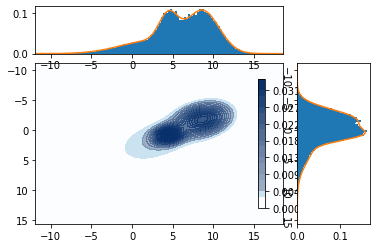

In [6]:
%matplotlib inline
# Plot a grid
fig = plt.figure()
gs = GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_hist_x = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

# lb, ub = gm5.interval()

ax_hist_y.hist(pf[:, feature1], density=True, bins=100)
lb, ub = ax_hist_y.get_xlim()
x = np.linspace(lb, ub, num=1000)
ax_hist_y.plot(x, gm5.pdf(x))
# dim 2

# lb, ub = gm6.interval()

ax_hist_x.hist(pf[:, feature2], orientation='horizontal', density=True, bins=100)
lb, ub = ax_hist_x.get_ylim()
y = np.linspace(lb, ub, num=1000)
ax_hist_x.plot(gm6.pdf(y), y)
ax_hist_x.invert_yaxis()
plt.yticks(rotation=270)
# Joint distribution
xx, yy = np.meshgrid(x, y)
positions = np.vstack([xx.ravel(), yy.ravel()]).T
pdf_values = gm4.pdf(positions).reshape(xx.shape)
# Define colormap
cmap = plt.cm.get_cmap('Blues', 3)
colors = cmap(np.arange(15))
# Modify alpha values to create a lighter colormap
colors[:, -1] = np.linspace(0.3, 1, 15)
# Create a new colormap using the modified colors
from matplotlib.colors import ListedColormap

light_cmap = ListedColormap(colors)
c = ax_scatter.contourf(xx, yy, pdf_values, cmap=light_cmap, levels=25)
plt.colorbar(c, cax=ax_scatter.inset_axes([0.9, 0.1, 0.03, 0.8]))